# Identity-oriented Tabular Image Transformation Prototype

Here we load data from the [CIC-Darknet2020](https://www.unb.ca/cic/datasets/darknet2020.html) dataset to explore methods of converting tabular data into image data using the Identity-oriented Tabular Image Transformation method.

In [1]:
import colorsys, datetime, os, pathlib, platform, pprint, sys
import fastai
import gtda
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image as Image
import plotly as py
import plotly.graph_objs as go
import seaborn as sns
import sdv
import sklearn
import yellowbrick as yb

from collections import namedtuple

from fastai.tabular.data import TabularDataLoaders, TabularPandas, MultiCategoryBlock
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from gtda.diagrams import PersistenceEntropy
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

from sdv.tabular import TVAE

from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve

seed: int = 14

# allow plots to be shown in the notebook
init_notebook_mode(connected=True)

Model_data = namedtuple(
    'model_data', 
    ['name', 'model', 'classes', 'X_train', 'y_train', 'X_test', 'y_test', 'to', 'dls', 'model_type']
)

Topology_data = namedtuple(
    'topology_data',
    ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'entropy', 'classes', 'target_label', 'clouds_y_decoded']
)

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# print library and python versions for reproducibility
print(
    f'''
    Last Execution: {datetime.datetime.now()}
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tgiotto-tda:\t{gtda.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tplotly:\t\t{py.__version__}
    \tseaborn:\t\t{sns.__version__}
    \tsdv:\t\t\t{sdv.__version__}
    \tsklearn:\t\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    Last Execution: 2022-03-14 00:02:18.984657
    python:	3.7.9

    	fastai:		2.5.3
    	giotto-tda:	0.5.1
    	matplotlib:	3.5.1
    	numpy:		1.21.5
    	pandas:		1.3.4
    	plotly:		5.6.0
    	seaborn:		0.11.2
    	sdv:			0.13.1
    	sklearn:		1.0.2
    	yellowbrick:	1.4
    


First we create some helper functions to load and process the data

In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function. 
        Function will return the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func



def load_data(filePath):
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    p = pathlib.Path(filePath)
    filePathClean: str = str(p.parts[-1])
    pickleDump: str = f'./cache/{filePathClean}.pickle'

    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')


    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
 
    # if not, load data and clean it before caching it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df



def features_with_bad_values(df: pd.DataFrame, datasetName: str) -> pd.DataFrame:
    '''
        Function will scan the dataframe for features with Inf, NaN, or Zero values.
        Returns a new dataframe describing the distribution of these values in the original dataframe
    '''

    # Inf and NaN values can take different forms so we screen for every one of them
    invalid_values: list = [ np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan', 0 ]
    infs          : list = [ np.inf, 'Infinity', 'inf' ]
    NaNs          : list = [ np.nan, 'NaN', 'nan' ]

    # We will collect stats on the dataset, specifically how many instances of Infs, NaNs, and 0s are present.
    # using a dictionary that will be converted into a (3, n) dataframe where n is the number of features in the dataset
    stats: dict = {
        'Dataset':[ datasetName, datasetName, datasetName ],
        'Value'  :['Inf', 'NaN', 'Zero']
    }

    i = 0
    for col in df.columns:
        
        i += 1
        feature = np.zeros(3)
        
        for value in invalid_values:
            if value in infs:
                j = 0
            elif value in NaNs:
                j = 1
            else:
                j = 2
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                feature[j] += len(indexNames)
                
        stats[col] = feature

    return pd.DataFrame(stats)



def clean_data(df: pd.DataFrame, prune: list) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the columns that match a value in prune 
        Inf and Nan values will also be removed once appropriate rows and columns 
        have been removed, 
        we will return the dataframe with the appropriate values
    '''

    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)

    return df


def get_n_color_list(n: int, opacity=.8, luminosity=.5, saturation=.5) -> list:
    '''
        Function creates a list of n distinct colors, formatted for use in a plotly graph
    '''

    colors = []

    for i in range(n):
        color = colorsys.hls_to_rgb(
                i / n,
                luminosity,
                saturation,
        )
        
        colors.append(f'rgba({color[0] * 255}, {color[1] * 255}, {color[2] * 255}, {opacity})')

    return colors


Classes and Wrappers

In [3]:
class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()


class Normal(Normalize):
    '''
        A data processing tool inherited from the fastai library. 
        This is a modified version of the normalize function that performs MinMax scaling and is able to be
            used in our preprocessing pipeline. 
        The original normalizes the data to have a mean centered at 0 and a standard deviation of 1.
    '''
    def setups(self, to):
        self.mins,self.maxs= getattr(to, 'train', to).conts.min(),getattr(to, 'train', to).conts.max()
        return self(to)

    def setups(self, to):
        self.mins,self.maxs= getattr(to, 'train', to).conts.min(),getattr(to, 'train', to).conts.max()
        return self(to)

    def decodes(self, to):
        to.conts = (to.conts) * (to.maxs - to.mins) + to.mins
        return to
        

@Normal
def setups(self, to):
    self.mins,self.maxs= getattr(to, 'train', to).conts.min(),getattr(to, 'train', to).conts.max()
    return self(to)


@Normal
def encodes(self, to):
    to.conts = (to.conts-self.mins) / (self.maxs - self.mins)
    return to


@Normal
def decodes(self, to):
    to.conts = (to.conts) * (to.maxs - to.mins) + to.mins
    return to

Dataset Manipulation tools

In [4]:
def examine_dataset(job_id: int) -> dict:
    '''
        Function will return a dictionary containing dataframe of the job_id passed in as well as that dataframe's
        feature stats, data composition, and file name.

        This dictionary is expected as the input for all of the other helper functions
    '''

    job_id = job_id - 1  # adjusts for indexing while enumerating jobs from 1
    print(f'Dataset {job_id+1}/{len(data_set)}: We now look at {file_set[job_id]}\n\n')

    # Load the dataset
    df: pd.DataFrame = load_data(file_set[job_id])
 

    # print the data composition
    print(f'''
        File:\t\t\t\t{file_set[job_id]}  
        Job Number:\t\t\t{job_id+1}
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             file_set[job_id],
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, file_set[job_id]), 
    }
    
    return data_summary



def package_data_for_inspection(df: pd.DataFrame) -> dict:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             '',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, ''), 
    }
    
    return data_summary



def package_data_for_inspection_with_label(df: pd.DataFrame, label: str) -> dict:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             f'{label}',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, f'{label}'),
    }
    
    return data_summary



def check_infs(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of Inf.
    '''

    
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    return inf_df[inf_df[0] != 0]



def check_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of NaN.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    return nan_df[nan_df[1] != 0]



def check_zeros(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T

    return zero_df[zero_df[2] != 0]



def check_zeros_over_threshold(data_summary: dict, threshold: int) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold]



def check_zeros_over_threshold_percentage(data_summary: dict, threshold: float) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with all features with
        a frequency of 0 values greater than the threshold
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    size: int = data_summary['Dataset'].shape[0]
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold*size]



def remove_infs_and_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return the dataset with all inf and nan values removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, [])

    return df



def rename_columns(data_summary: dict, columns: list, new_names: list) -> dict:
    '''
        Function will return the data_summary dict with the names of the columns in the dataframe changed
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for x, i in enumerate(columns):
        df.rename(columns={i: new_names[x]}, inplace=True)

    data_summary['Dataset'] = df

    return data_summary



def rename_values_in_column(data_summary: dict, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for i in range(length):
        df[replace[i][0]].replace(replace[i][1], inplace=True)


    return df



def prune_dataset(data_summary: dict, prune: list) -> pd.DataFrame:
    '''
        Function will return the dataset with all the columns in the prune list removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, prune)

    return df



def prune_feature_by_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed

        Deprecated, use reduce_feature_to_values:
            ambiguous name implied it is removing values, not keeping them
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def reduce_feature_to_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def test_infs(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no inf values.
    '''
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    assert inf_df[inf_df[0] != 0].shape[0] == 2, 'Dataset has inf values'
    

    return True



def test_nans(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no NaN values
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    assert nan_df[nan_df[1] != 0].shape[0] == 2, 'Dataset has NaN values'


    return True



def test_pruned(data_summary: dict, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    pruned: bool = True

    for col in prune:
        if col in data_summary['Dataset'].columns:
            pruned = False

    assert pruned, 'Dataset has columns present in prune list'

    return pruned



def test_pruned_size(data_summary_original: dict, data_summary_pruned: dict, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    original_size: int = data_summary_original['Dataset'].shape[1]
    pruned_size: int = data_summary_pruned['Dataset'].shape[1]
    prune_list_size: int = len(prune)

    assert original_size - prune_list_size == pruned_size, 'Dataset has columns present in prune list'

    return True

Now, we specify what datasets we want to load.

In [5]:
# This code is used to scale to processing numerous datasets, even though we currently are only looking at one now
data_path_1: str = './phase1/'   
data_set_1: list = [
    'Darknet_reduced_features.csv',
]

data_set: list   = data_set_1
file_path_1      = get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0


Functions to run classification experiments or to transform and split the data

In [6]:
def run_deep_nn_experiment(df: pd.DataFrame, name: str, target_label: str, shape: tuple, categorical: list = ['Protocol'], scale: bool= False, leave_out: list = []) -> Model_data:
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
        returns the 8-tuple with the following indicies:
        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    print(df.shape)
    assert len(shape) == 2, 'Shape must be a tuple of length 2'
 
    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    if(scale):
        procs.append(Normal)
    
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up

    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # extract the name from the path
    p = pathlib.Path(name)
    name: str = str(p.parts[-1])

    # Next, we set up, train, and save the deep neural network
    model = tabular_learner(
        dls, 
        layers=list(shape), 
        metrics=accuracy, 
        cbs=ShowGraphCallback,
    )

    model.fit_one_cycle(10)
    model.save(f'{name}.model')

    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # A confusion matrix is created to help evaluate the results
    interp = ClassificationInterpretation.from_learner(model)
    interp.plot_confusion_matrix()

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = SklearnWrapper(model)

    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = dep_var
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    model_data: Model_data = Model_data(name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, f'Deep_NN_{shape[0]}x{shape[1]}')


    return model_data



def run_knn_experiment(df: pd.DataFrame, name: str, target_label: str, categorical : list = ['Protocol'], leave_out: list = []) -> Model_data:
    '''
        Run binary classification using K-Nearest Neighbors
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label
    print(df.shape)

 
    categorical_features: list = []
    untouched_features  : list = []


    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # extract the name from the path
    p = pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    # params = {"n_neighbors": range(1, 50)}
    # model = GridSearchCV(KNeighborsClassifier(), params)
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    report = classification_report(y_test, prediction)
    print(report)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')
    # print("Best Parameters found by gridsearch:")
    # print(model.best_params_)


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, f'K_Nearest_Neighbors')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data



def transform_and_split_data(df: pd.DataFrame, target_label: str, split=0.2, name='', categorical : list = ['Protocol'], scale:bool = False, leave_out: list = []) -> Model_data:
    '''
        Transform and split the data into a train and test set
        returns the 10-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var             : str  = target_label
    categorical_features: list = []
    untouched_features  : list = []

    print(df.shape)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    if(scale): 
        procs.append(Normal)

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        model.target_type_ = 'single'
        
    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, 'Transformed_and_Split_data')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

Dataset Preparation Tools


In [7]:
def decode_classes_and_create_Xy_df(model_data: Model_data, target_label: str):
    """
        Function takes a Model_data namedtuple and returns a dataframe with the X and decoded y data
    """
    X = model_data.X_train
    y = model_data.y_train
    classes = model_data.classes

    Xy_df = pd.DataFrame(X)
    y_s: list = []
    for x in y:
        y_s.append(classes[x])
    Xy_df[target_label] = y_s

    return Xy_df


def normalize_bilabel_dataset_between_0_1(df: pd.DataFrame, labels = ['Traffic Type', 'Application Type']) -> pd.DataFrame:
    '''
        Function takes a dataframe and merges its labels before normalizing data. 
        The labels are then split back into their original form, but the merged label is kept for verification purposes.

        returns a trilabel dataframe with the new label under the 'Merged Type' column
    '''
    inter_df = df.copy()

    d1_y = inter_df[labels[0]]
    d2_y = inter_df[labels[1]]

    merged_y = pd.concat([d1_y, d2_y], axis=1)

    merged: list = []
    for x in zip(d1_y, d2_y):
        merged.append(f'{x[0]}_{x[1]}')

    inter_df['Merged Type'] = merged

    normalized_model_data = transform_and_split_data(
        inter_df,
        'Merged Type',
        split=0,
        scale=True,
        categorical=[],
        leave_out=labels
    )

    merged_df = decode_classes_and_create_Xy_df(normalized_model_data, 'Merged Type')

    merged_y = merged_df['Merged Type']
    new_labels: list = []

    for l in labels:
        new_labels.append([])

    for x in merged_y:
        split_label = x.split('_')

        for i in range(len(split_label)):
            new_labels[i].append(split_label[i])

    for i, x in enumerate(labels):
        merged_df[x] = new_labels[i]

    total_df = merged_df.copy()
    total_df['Merged Type'] = merged_y


    return total_df

    

def create_n_cloud_from_dataset(df: pd.DataFrame, n_points: int = 100, target_label: str = 'label', allow_partial: bool = False, segmented=True):
    '''
        Function takes a dataframe and splits it into point clouds with n_points each. 
            The generated clouds will all have the indicated number of points, discarding the remainder if allow_partial is False.
            The generated clouds will be partitioned by the classes contained within the target_label column.
            Each cloud will be labeled with the class it was generated from.

            If the segmented parameter is true, the clouds will be split into df.shape[0]/n_points number of clouds.
                This is because we segment the dataframe to produce the clouds.
            if the segmented parameter is false, the clouds will be split into df.shape[0] - n_points number of clouds.
                This is because we will be using a sliding interval to construct the clouds.

        returns a numpy array of point clouds as well as a numpy array with class labels and class mappings.
    '''

    data = transform_and_split_data(df, target_label=target_label, split=0)
    X = data.X_train.copy()
    X[target_label] = data.y_train.copy()

    classes = data.classes

    # create n clouds by class
    clouds          : list = []
    clouds_y        : list = []
    clouds_y_decoded: list = []

    for i, x in enumerate(classes):
        temp_df = X[X[target_label] == i]
        if(segmented):
            iterations: int = int(temp_df.shape[0]/n_points)
        else:
            iterations: int = temp_df.shape[0] - n_points


        for j in range(int(iterations)):
            if(segmented):
                cloud = temp_df[j*n_points:(j+1)*n_points].drop(target_label, axis=1).values
            else:
                cloud = temp_df[j:j+n_points].drop(target_label, axis=1).values
            
            keep: bool = allow_partial and not segmented
            if(len(cloud) == n_points or keep):
                clouds.append(cloud)
                clouds_y.append(i)
                clouds_y_decoded.append(x)

    clouds = np.array(clouds)
    clouds_y = np.array(clouds_y)
    clouds_y_decoded = np.array(clouds_y_decoded)

    return clouds, clouds_y, classes, clouds_y_decoded


def calculate_correlations(model_data: Model_data, target_label: str):
    '''
        Function merges together the encoded and standardized model data and labels to calculate pearson correlation
    '''

    encoded_data = model_data.X_train.copy()
    encoded_data[target_label] = model_data.y_train

    return encoded_data.corr()


def extract_correlations(correlations: pd.DataFrame, feature: str, leave_out: list = ['Traffic Type', 'Application Type']) -> list:
    '''
        Function takes a correlation dataframe and extracts a list of features correlated with the input feature. 
            Anything in leave_out is not included in the list.
    '''

    correlation_order: list = list(correlations.sort_values(by=feature, ascending=False).index)

    for x in leave_out:
        if x in correlation_order:
            correlation_order.remove(x)

    return correlation_order

Mathematical functions on the interval [0,1] with unary function proceeded by binary functions

In [8]:
# unary functions

def clamp_to_0_1(x):
    return max(min(x, 1), 0)

def p_2_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a second degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(2, 2*(x-.5))

def p_4_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a fourth degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(4, 2*(x-.5))

def p_6_pot(x):
    ''' 
        A pot shape in the interval [0,1] using a sixth degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    return np.power(6, 2*(x-.5))

def gaussian_spike(x):
    return np.exp(-np.power(x, 2))

def double_gaussian_spike(x):
    ''' 
        A double gaussian spike shape in the interval [0,1]
            gives larger changes in gradient to spread around input 
            in the interval [0,1]
    '''

    first_spike  = (-0.5) * gaussian_spike((53*x) - 2.2)
    second_spike = gaussian_spike((2.7*x) - 2.2)

    return first_spike + second_spike

def sharp_zero_spike(x):
    return 1 - np.exp(-np.power(np.power((200*x), 2)+0.0001, -1))

def curve_over_x_1(x):
    '''
        A curve on the interval [0,1] that maps 0 to 0 and 1 to 1 but stays above
            the line f(x) = x
    '''

    return x*np.exp(1-x)

def curve_over_x_2(x):
    return -(x - 1)*(x - 1) + 1


# binary functions / operations
# _ precedes names to prevent name conflicts

def _dist_l1(x, y):
    return np.abs(x - y)

def _dist_l2(x, y):
    return np.sqrt(np.power(x, 2) + np.power(y, 2))

def _avg(x, y):
    return (x + y) / 2

def _mult(x, y):
    return x * y

def _add(x, y):
    return x + y

def _rbf_l1(x, y):
    '''radial basis function'''
    return np.exp(-_dist_l1(x, y)**2)

def _rbf_l2(x, y):
    '''radial basis function'''
    return np.exp(-_dist_l2(x, y)**2)


# closures allowing customizable functions

def mult_by_n(n):
    def f(x):
        return n * x
    return f


def p_n_pot(n):
    ''' 
        A pot shape in the interval [0,1] using an nth-degree polynomial
        0 and 1 are mapped to 1 and .5 is mapped to 0
    '''
    def f(x):
        return np.power(n, 2*(x-.5))
    return f



Functions to automate the Identity-oriented Tabular Image Transformation

In [9]:
def produce_single_channel_image_matrix(
    df_sample: pd.DataFrame, 
    row_ordering: list, 
    column_ordering: list, 
    padding: tuple, 
    identity: float = 1, 
    operation: callable = lambda x, y: x*y,
    activation: callable = lambda x: x,
) -> np.ndarray:
    '''
    Function will create a len(row_ordering) x len(column_ordering) matrix
        representing the input sample.
    
    This uses the Identity-oriented Tabular Image Transformation algorithm to produce an image from tabular data:
            From the sample, two vectors reordered by the specified row and column ordering are padded with identity values
                before the operation is then applied to the generalised outer product of the vectors.

            Since we have an identity (or constant value if an identity does not exist), the top right corner with a size dictated 
                by the padding parameter will have a monochromatic square the allows classifiers to understand the orientation 
                of the image.

            The padding[0]xlen(row_ordering) and len(column_ordering)xpadding[1] submatrices will contain feature bands that 
                are meant to communicate the true values of the input features to the classifier

            The remaining interior submatrix will contain the nested feature geometry imposed by the operation on the 
                outer product of the feature vectors ordered by the input row_ordering and column_ordering vectors.

            An activation function is called on the output of the operation in order to tune the output before being clamped 
                to the interval [0,1]. 

            The produced image is called a Symmetric Identity-oriented Tabular Image if and only if these conditions are met
                1) the row_ordering and column_ordering vectors are the same or are in reversed order
                2) padding[0] = padding[1]
                3) the operation (binary function) being performed is commutative, i.e. f(a, b) = f(b, a)

            The produced image is called an Asymmetric Identity-oriented Tabular Image if it does not fulfill one of the above conditions.
    '''

    row_vector    = [identity] * padding[0] + list(df_sample.reindex(columns=row_ordering   ).values[0])
    column_vector = [identity] * padding[1] + list(df_sample.reindex(columns=column_ordering).values[0])

    product: callable = lambda x, y: clamp_to_0_1(activation(operation(x, y)))
    composed_outer = np.frompyfunc(product, 2, 1)

    pic = composed_outer.outer(row_vector, column_vector).astype(np.float64)

    return pic
    

##### Clustering Functions

Clustering using Linear Feature Reduction through Principal Component Analysis

In [10]:
def show_clusters_by_label_1D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes the 10-tuple model_data from the transform and split function and uses Principal component analysis
            to break up the feature dimensions into a single dimension for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=1)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1"]

    _X              = pd.concat([X, component], axis=1, join='inner')
    new_X           = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns   = _X.columns
    new_X["filler"] = 0


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x=cluster["component_1"],
                y=cluster["filler"],
                mode='markers',
                marker = dict(color = label_colors[i]),
                name=classes[i],
            )
        )

    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5,zeroline= False
        ),
        yaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_2D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into two dimension  for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=2)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_3D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into three dimensions for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=3)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter3d(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                z      = cluster["component_3"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_4D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into four dimensions for cluster analysis.
            Displays a 2 two-dimensional graphs of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=4)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3", "component_4"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces1: list = []
    traces2: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces1.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )
        traces2.append(
            go.Scatter(
                x      = cluster["component_3"]    ,
                y      = cluster["component_4"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout1 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )

    layout2 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 3',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 4',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces1, 'layout': layout1})
    iplot({'data': traces2, 'layout': layout2})

Clustering using Non-Linear Feature Reduction through T-Stochastic Neighbor Embeddings

In [11]:
def show_clusters_by_label_1D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into a single dimension for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X           = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns   = X.columns
    new_X["filler"] = 0


    tsne              = TSNE(n_components=1, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(['label'], axis=1)))
    component.columns = ["component_1"]
    new_X             = pd.concat([X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x=cluster["component_1"],
                y=cluster["filler"],
                mode='markers',
                marker = dict(color = label_colors[i]),
                name=classes[i],
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5,zeroline= False
        ),
        yaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_2D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into two dimension  for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    tsne              = TSNE(n_components=2, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(columns=['label'], axis=1)))
    component.columns = ["component_1", "component_2"]
    new_X             = pd.concat([new_X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_3D_tsne(model_data: tuple, samples=25000, title='Clusters by Label', perplexity: int = 50) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses T-Distributed Stochastic Neighbor Embedding
            to break up the feature dimensions into three dimensions for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    tsne              = TSNE(n_components=3, perplexity=perplexity)
    component         = pd.DataFrame(tsne.fit_transform(new_X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3"]
    new_X             = pd.concat([new_X, component], axis=1, join='inner')


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter3d(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                z      = cluster["component_3"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title    = 'Component 1',
            ticklen  = 5            ,
            zeroline = False        ,
        ),
        yaxis= dict(
            title    = 'Component 2',
            ticklen  = 5            ,
            zeroline = False        ,
        )
    )


    iplot({'data': traces, 'layout': layout})

Clustering using tools built using Topological Data Analysis

In [12]:
def calculate_single_batch_dataset_topology(model_data: tuple, samples: int or None = 1000, dimensions: tuple = (0,1), title=''):
    """
    Function calculates the topology of the dataset and returns it
        requires data to be transformed by fastai first to properly encode and normalize the
        data.

    Returns a namedtuple with the following fields:
        title: Graph title
        persistence: Vietoris-Rips Peristence
        fig: plotly figure
        entropy: Persistence Entropy

    """

    if(model_data.name != '' and title == ''):
        title = model_data.name


    if(samples is None):
        X = model_data.X_train.values
    else:
        X = model_data.X_train.sample(samples).values
        
    X = np.array([X])

    # calculate the topology
    VR = VietorisRipsPersistence(homology_dimensions=dimensions)
    topology = VR.fit_transform(X)

    # calculate the persistence diagram
    fig = plot_diagram(topology[0])

    # calculate the entropy
    PE = PersistenceEntropy()
    entropy = PE.fit_transform(topology)

    # package in topological_data named tuple. We do this so data can be accessed using [i] or . operators
    topological_data: Topology_data = Topology_data(title, X, None, topology, fig, entropy, model_data.classes, '', None)

    return topological_data


def run_tda_on_dataset(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, dimension: tuple = (0,1), allow_partial: bool = False) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            the indicated dimensions corresponding to topological features like connectivity(0d), loopiness(1d), caviatation(2d), etc
            for cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.

        Returns the topological data for the dataset

        Topology_data = namedtuple(
           'topology_data',
            ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'entropy', 'classes', 'target_label', 'clouds_y_decoded']
        )
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial)

    VR = VietorisRipsPersistence(homology_dimensions=dimension)
    PE = PersistenceEntropy()

    topologies = VR.fit_transform(clouds)

    X = pd.DataFrame(PE.fit_transform(topologies))

    col: list = []
    for n in dimension:
        col.append(f'{n}d entropy')
    X.columns = col


    X[target_label] = clouds_y

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, None, X, classes, target_label, clouds_y_decoded)

    return topology_data


def show_clusters_by_label_2D_tda(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, allow_partial: bool = False) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            two dimensions corresponding to connectivity and loopinessfor cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.
            Displays a graph of the clusters colored by label

        Returns the topological data for the dataset
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial)

    VR = VietorisRipsPersistence(homology_dimensions=(0,1))
    PE = PersistenceEntropy()

    topologies      = VR.fit_transform(clouds)

    X               = pd.DataFrame(PE.fit_transform(topologies))
    X.columns       = ["Connectivity", "Loopiness"]
    X[target_label] = clouds_y
    num_labels      = len(X.groupby(target_label).size())
    label_colors    = get_n_color_list(num_labels, opacity=.4)


    traces: list = []
    for i in range(num_labels):
        cluster = X[X[target_label] == i]
        traces.append(
            go.Scatter(
                x      = cluster["Connectivity"]   ,
                y      = cluster["Loopiness"]      ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Connectivity',
            ticklen= 5           ,
            zeroline= False      ,
        ),
        yaxis= dict(
            title= 'Loopiness',
            ticklen= 5        ,
            zeroline= False   ,
        )
    )

    fig = {'data': traces, 'layout': layout}

    iplot(fig)

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, fig, X, classes, target_label, clouds_y_decoded)

    return topology_data


def extract_topological_correlations(topology_data: Topology_data, original_dataset: pd.DataFrame, label: str):
    '''
        Takes a Topology_data namedtuple and returns a dictionary of lists of features ordered topological correlations 
            for each value in the topology_data.entropy dataframe with the values of the points in the point clouds
            being used to calculate the persistence entropy
    '''        

    cols = list(original_dataset.columns)
    if(label in cols):
        cols.remove(label)

    df = pd.DataFrame()
    new_cols = list(topology_data.entropy.columns)
    for i, x in enumerate(topology_data.clouds):
        new_df = pd.DataFrame(x)
        for col in new_cols:
            new_df[col] = topology_data.entropy[col][i]
        df = pd.concat([df, new_df], ignore_index=True)

    df.columns = cols + new_cols

    correlation = df.corr()

    correlations: dict = {}
    for col in new_cols:
        if col != label:
            correlations[col] = extract_correlations(correlation, col)

    for cor in correlations.keys():
        for col in new_cols:
            if col in correlations[cor]:
                correlations[cor].remove(col)


    correlations['Graph'] = plt.figure(figsize=(20,15))
    sns.heatmap(correlation, vmax=1, square=True, cmap='YlGnBu')
    plt.title("Topographic Correlation Heatmap for n_clouds Generated by Traffic Type", fontsize=16)

    return correlations



Tools to visualize the results of classification experiments

In [13]:
def visualize_confusion_matrix(model_data: tuple) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and creates a confusion matrix

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0])
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer.show()



def visualize_roc(model_data: tuple) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ROCAUC(model_data[1], classes=model_data[2], title=model_data[0])
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer.show()



def visualize_pr_curve(model_data: tuple) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(model_data[1], title=model_data[0])
    visualizer.score(model_data[5], model_data[6])

    return visualizer.show()



def visualize_report(model_data: tuple) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ClassificationReport(model_data[1], classes=model_data[2], title=model_data[0], support=True)
    visualizer.score(model_data[5], model_data[6])

    return visualizer.show()



def visualize_class_balance(model_data: tuple) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.target.ClassBalance(labels=model_data[0])
    visualizer.fit(model_data[4], model_data[6])
    
    return visualizer.show()



def confusion_matrix_from_dataset(model_data: tuple, df: pd.DataFrame) -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses the model to classify
            the data passed in as the dataframe. Produces a confusion matrix
            (currently only confirmed to work with fastai models)

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    dl = model_data[1].model.dls.test_dl(df, bs=64)
    preds, v, dec_preds = model_data[1].model.get_preds(dl=dl, with_decoded=True)

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0])
    visualizer.score(dl.xs, dl.y)
    viz = visualizer.show()
    acc = accuracy_score(dl.y, dec_preds)
    print(f'Accuracy: {acc}')

    return viz


def show_stacked_graphs(figures: list, stack_shape: tuple = (1,1), title: str = '', individual_titles: list or str = None): 
    """
    Function takes a list of figures and stacks them in a grid.
        stack_shape is a tuple of the number of rows and columns in the grid and
        the product of the indices must equal the number of figures.
        individual_titles allows one to specify titles for each figure, or a single title for all figures.

    Returns a plotly figure with the input figures stacked as indicated
    """

    if(individual_titles is not None and type(individual_titles) is not str):
        assert len(figures) == len(individual_titles)     , "Number of titles must match number of figures"
    assert len(figures) == stack_shape[0] * stack_shape[1], "Number of figures must match stack shape"

    vertical_stack  : list = []
    horizantal_stack: list = []

    if(title != ''):
        vertical_stack.append(widgets.Label(title))
    
    for i in range(stack_shape[1]):
        for j in range(stack_shape[0]):
                
            temp_fig = go.FigureWidget(figures[i * stack_shape[0] + j].data)
            if(type(individual_titles) == str):
                temp_fig.layout.title = individual_titles
            elif(type(individual_titles) == list):
                temp_fig.layout.title = individual_titles[i * stack_shape[0] + j]
                
            horizantal_stack.append(temp_fig)
        vertical_stack.append(widgets.HBox(horizantal_stack))
        horizantal_stack = []

    fig = widgets.VBox(vertical_stack)

    return fig



In [14]:
print(f'We will be looking at {len(file_set)} files:')
pretty(file_set)

We will be looking at 1 files:
[   './phase1/Darknet_reduced_features.csv']


## Loading Datasets

We load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We will show correlations in both datasets, extract the correlations to labels or features, and use these to construct images from the data.

In [28]:
dataset_1            : dict = examine_dataset(1)
traffic_dataset_1    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Application Type']), 'Traffic_Dataset_1')
application_dataset_1: dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Traffic Type']), 'Application_Dataset_1')

Dataset 1/1: We now look at ./phase1/Darknet_reduced_features.csv


Loading Dataset: ./phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				./phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    

        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    

        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    


We standardize and encode the data so we can detect correlations between features and labels.

In [16]:
traffic_dataset_1['Data'] = transform_and_split_data(
    traffic_dataset_1['Dataset'],
    'Traffic Type',
    split=0,
)


application_dataset_1['Data'] = transform_and_split_data(
    application_dataset_1['Dataset'],
    'Application Type',
    split=0,
)

(141481, 63)
(141481, 63)


In [17]:
application_dataset_1['Correlations'] = calculate_correlations(application_dataset_1['Data'], 'Application Type')
traffic_dataset_1['Correlations'] = calculate_correlations(traffic_dataset_1['Data'], 'Traffic Type')

Now we graph the correlations

Text(0.5, 1.0, 'Correlation Heatmap with Application Type Label')

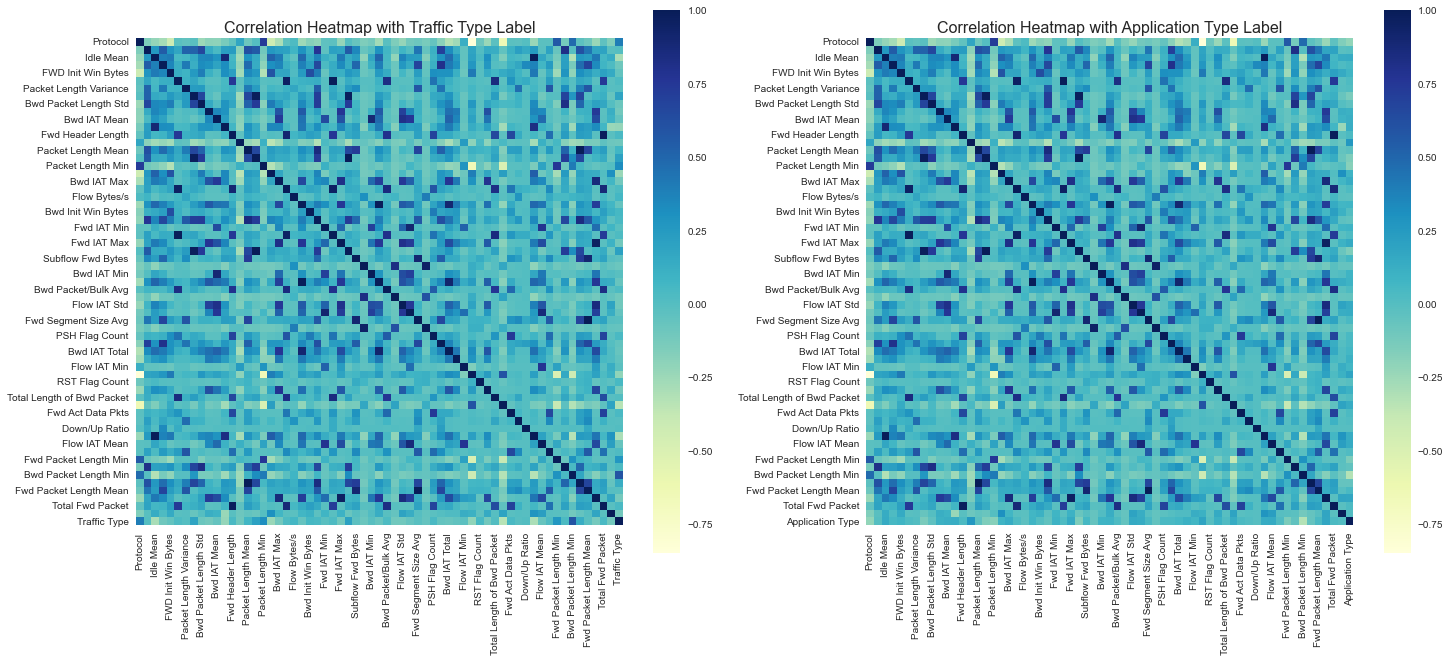

In [18]:
fig, axes = plt.subplots(1,2, figsize=(24, 10))
sns.heatmap(traffic_dataset_1['Correlations'], vmax=1, square=True, cmap='YlGnBu', ax=axes[0])
sns.heatmap(application_dataset_1['Correlations'], vmax=1, square=True, cmap='YlGnBu', ax=axes[1])
axes[0].set_title("Correlation Heatmap with Traffic Type Label", fontsize=16)
axes[1].set_title("Correlation Heatmap with Application Type Label", fontsize=16)

Now we extract lists of features that are correlated to a label or feature in order of correlation strength. 

Then we normalize and encode the data to be used in the image construction.

In [19]:
labels = ['Traffic Type', 'Application Type']
traffic_dataset_1['Traffic Type Correlations'] = extract_correlations(traffic_dataset_1['Correlations'], 'Traffic Type', labels)
traffic_dataset_1['Protocol Correlations'] = extract_correlations(traffic_dataset_1['Correlations'], 'Protocol', labels)
df = normalize_bilabel_dataset_between_0_1(dataset_1['Dataset'], labels)


(141481, 65)


Now we produce the images channel by channel so we can see exactly how the different channels combine into the final image.

We experiment with different operations and activation functions to find the most expressive way to transform the data.

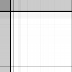

In [20]:
m = produce_single_channel_image_matrix(
    df[:1], 
    traffic_dataset_1['Traffic Type Correlations'], 
    traffic_dataset_1['Protocol Correlations'], 
    (10,10), 
    identity=0.2, 
    operation=_add, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    # activation=mult_by_n(13)
    # activation=p_6_pot
)

pic1 = Image.fromarray(np.uint8((1-m)*255), 'L')
display(pic1)

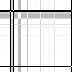

In [21]:
n = produce_single_channel_image_matrix(
    df[:1], 
    traffic_dataset_1['Traffic Type Correlations'], 
    traffic_dataset_1['Protocol Correlations'], 
    (10,10), 
    identity=0, 
    operation=_dist_l1, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    activation=mult_by_n(8)
    # activation=p_6_pot
)

pic2 = Image.fromarray(np.uint8((1-n)*255), 'L')
display(pic2)

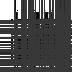

In [22]:
o = produce_single_channel_image_matrix(
    df[:1], 
    traffic_dataset_1['Traffic Type Correlations'], 
    traffic_dataset_1['Protocol Correlations'], 
    (10,10), 
    identity=1, 
    operation=_mult, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    # activation=mult_by_n(13)
    # activation=p_6_pot
    # activation=sharp_zero_spike
    # activation=gaussian_spike
    # activation=lambda x: gaussian_spike(1000*x) + gaussian_spike(1000*x-.5)
    # activation=lambda x: gaussian_spike(1000*x) 
    activation=lambda x: gaussian_spike(10000*x-.5)
)

pic3 = Image.fromarray(np.uint8((1-o)*255), 'L')
display(pic3)

Now that we have 3 channels of the image produced, we can combine them into a 3 channel image, encoding a deep and rich representation of the sample.

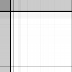

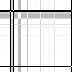

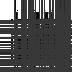

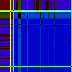

In [23]:
new_pic = np.array((m, n, o)).transpose(1,2,0)
final_pic = Image.fromarray(np.uint8((new_pic)*255), 'RGB')
display(pic1, pic2, pic3, final_pic)


In [24]:
final_pic.show()

Now we do the same thing, however we extract the features that correlate most to the topological features of the dataset.

In [29]:
traffic_dataset_1['n_100_TDA_0_1'] = run_tda_on_dataset(traffic_dataset_1['Dataset'], target_label='Traffic Type', n_points=100, dimension=(0,1))

(141481, 63)


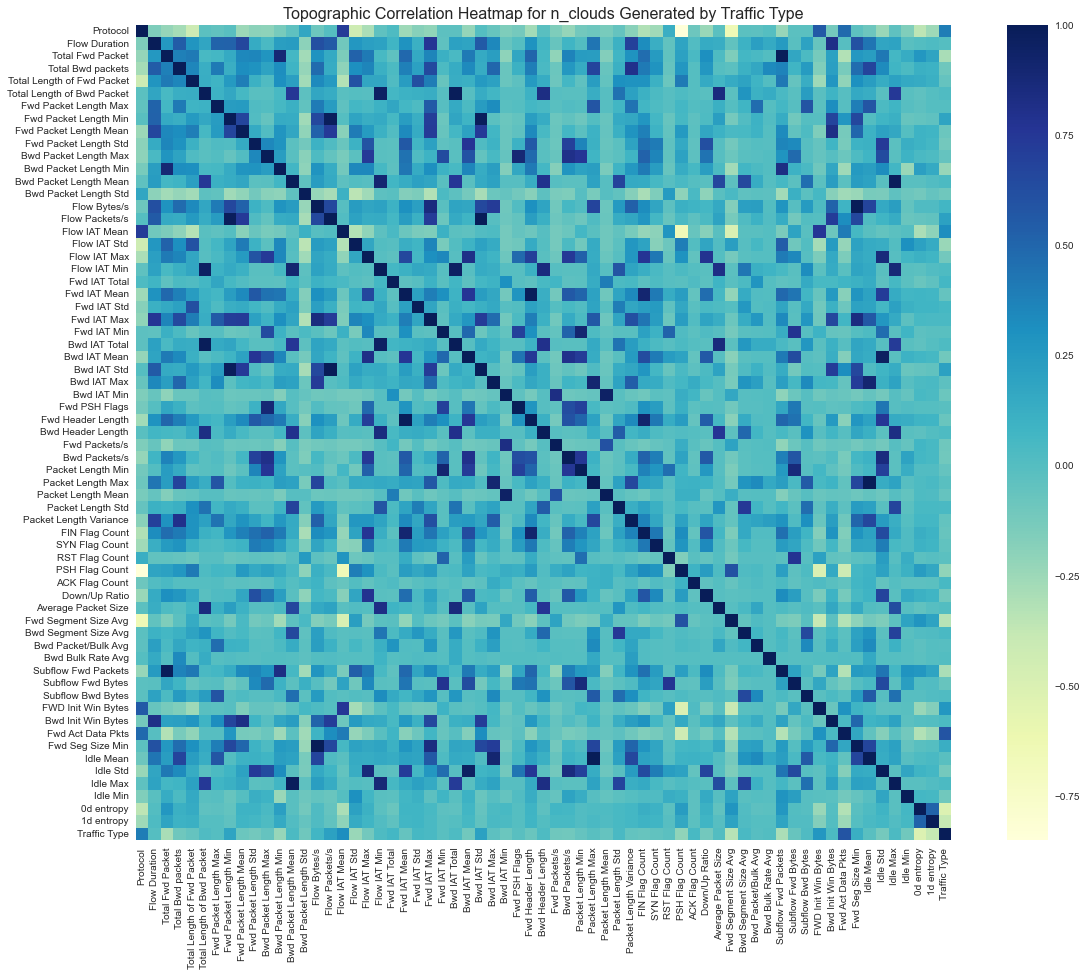

In [30]:
traffic_topology_correlations: dict = extract_topological_correlations(traffic_dataset_1['n_100_TDA_0_1'], traffic_dataset_1['Dataset'], 'Traffic Type')
keys = list(traffic_topology_correlations.keys())
top_corr_0d = traffic_topology_correlations[keys[0]]
top_corr_1d = traffic_topology_correlations[keys[1]]

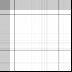

In [31]:
t_m = produce_single_channel_image_matrix(
    df[:1], 
    top_corr_0d,
    top_corr_1d, 
    (10,10), 
    identity=0.2, 
    operation=_add, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    # activation=mult_by_n(13)
    # activation=p_6_pot
)

t_pic1 = Image.fromarray(np.uint8((1-t_m)*255), 'L')
display(t_pic1)

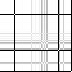

In [32]:
t_n = produce_single_channel_image_matrix(
    df[:1], 
    top_corr_0d, 
    top_corr_1d, 
    (10,10), 
    identity=0, 
    operation=_dist_l1, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    activation=mult_by_n(8)
    # activation=p_6_pot
)

t_pic2 = Image.fromarray(np.uint8((1-t_n)*255), 'L')
display(t_pic2)

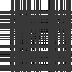

In [33]:
t_o = produce_single_channel_image_matrix(
    df[:1], 
    top_corr_0d, 
    top_corr_1d, 
    (10,10), 
    identity=1, 
    operation=_mult, 
    # activation=double_gaussian_spike
    # activation=curve_over_x_2
    # activation=mult_by_n(13)
    # activation=p_6_pot
    # activation=sharp_zero_spike
    # activation=gaussian_spike
    # activation=lambda x: gaussian_spike(1000*x) + gaussian_spike(1000*x-.5)
    # activation=lambda x: gaussian_spike(1000*x) 
    activation=lambda x: gaussian_spike(10000*x-.5)
)

t_pic3 = Image.fromarray(np.uint8((1-t_o)*255), 'L')
display(t_pic3)

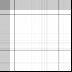

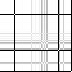

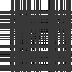

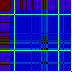

In [34]:
t_new_pic = np.array((t_m, t_n, t_o)).transpose(1,2,0)
t_final_pic = Image.fromarray(np.uint8((t_new_pic)*255), 'RGB')
display(t_pic1, t_pic2, t_pic3, t_final_pic)


In [35]:
t_final_pic.show()

In [36]:
print(f'Last Execution: {datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-03-14 00:13:23.839549


AssertionError: Nothing after this point is included in the study